In [1]:
import os, sys, json, pickle, itertools, numpy as np, pandas as pd, scipy.sparse as sp
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_auc_score
import networkx as nx

import torch, torch.nn as nn, torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import dgl, dgl.nn.pytorch.conv as conv

import phate, umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('..')
from gode.utils import get_device

/gpfs/gibbs/project/gerstein/kx44/conda_envs/ritini/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_device()

# seed for repeatability
torch.backends.cudnn.deterministic = True # make cudnn behave deterministically, impotant if you want to reproduce 
torch.backends.cudnn.benchmark = False # disable the cuDNN auto-tuner. 
# Setting this to False is essential when you want consistent (deterministic) results rather than varying performance optimizations.

seed = 3
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
device

'cuda'

In [4]:
data_path = "/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/alzheimer/results"

In [5]:
traj_data = np.load(f"{data_path}/microglia_subtraj_gene_space_for_ritini.npz", allow_pickle=True)

In [6]:
preds = np.load(f"{data_path}/32-granger-preds.npy")
genes = np.load(f"{data_path}/32-granger-genes.npy", allow_pickle=True)

In [7]:
adata = np.load(f"{data_path}/34-adata.npz", allow_pickle=True)

In [8]:
data = preds[0,...]

In [9]:
top_data = data
top_genes = genes

In [10]:
top_data[23,45]

4.033473365645731

In [11]:
import networkx as nx
# Create a directed graph from the adjacency matrix
G = nx.DiGraph()

# Add nodes with labels
for i, label in enumerate(top_genes):
    G.add_node(i, label=label)

# Add edges based on the adjacency matrix
for i in range(top_data.shape[0]):
    for j in range(top_data.shape[1]):
        if top_data[i, j] >= 5.:  # why the cutoff set as 5.0 here? 
            G.add_edge(i, j)

# Extract node labels
# labels = nx.get_node_attributes(G, 'label')

# Draw the graph
# pos = nx.spring_layout(G.to_undirected())  # Positioning of nodes
# plt.figure(figsize=(10,10))
# nx.draw(G, pos, with_labels=True, labels=labels, node_size=100, node_color='lightblue', edge_color='gray', arrows=True)
# # nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): top_data[i, j] for i, j in G.edges()}, font_color='red')

# plt.show()

In [12]:
edges = list(G.edges()) # Converts the edges of the NetworkX graph G into a list of tuples.
u, v = np.array(edges).T # u becomes an array of source nodes and v becomes an array of destination nodes.
u = torch.IntTensor(u)
v = torch.IntTensor(v)


g = dgl.graph((u, v))
num_edges = g.number_of_edges()

# Assign a default edge weight of 1.0 to all edges
# g.edata['weight'] = torch.ones(num_edges)

g.ndata['feat'] = torch.Tensor(np.ones((len(g.nodes()), 1)))

# g = dgl.from_networkx(G)
# g.ndata['feat'] = torch.Tensor(np.ones((len(g.nodes()), 1)))


ref_g = g.to_networkx()
ref_pos = nx.spring_layout(ref_g.to_undirected(), seed=seed)

for idx, node in enumerate(ref_g.nodes()):
    ref_g.nodes[idx]['color'] = plt.get_cmap('viridis', len(top_genes))(idx)
    ref_g.nodes[idx]['label'] = top_genes[idx]

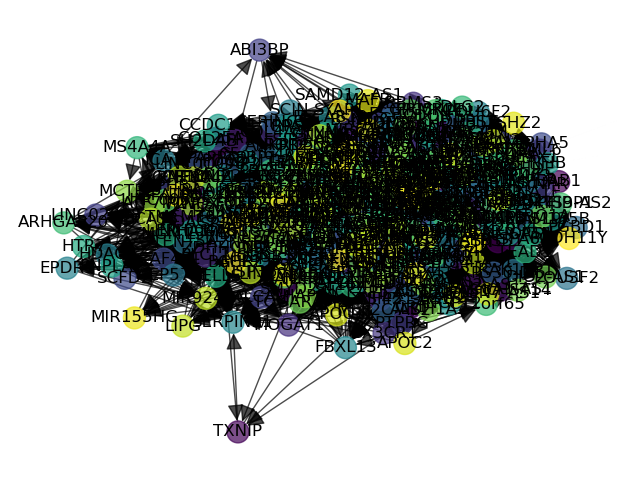

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)

nx.draw_networkx_labels(
    ref_g, pos=ref_pos, ax=ax,
    labels=nx.get_node_attributes(ref_g,'label'),
    font_size=12, font_color='black'
)

nx.draw(
    ref_g, pos=ref_pos, ax=ax,
    with_labels=False,
    node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
    edge_cmap=plt.cm.magma,
    node_size=250, arrowsize=25, alpha=0.7
)

In [14]:
# Mapping for edge ids
edge_ids = np.arange(g.number_of_edges())

# Shuffle
edge_ids = np.random.permutation(edge_ids)

test_size_percent = 30
test_size_fraction = test_size_percent / 100

edge_test_size = int(len(edge_ids) * test_size_fraction)
edge_train_size = g.number_of_edges() - edge_test_size

In [15]:
edge_test_pos_u = u[edge_ids[:edge_test_size]]
edge_test_pos_v = v[edge_ids[:edge_test_size]]

edge_train_pos_u = u[edge_ids[edge_test_size:]]
edge_train_pos_v = v[edge_ids[edge_test_size:]]

In [16]:
adjaceny_matrix = nx.adjacency_matrix(G)
adjaceny_matrix_negative = 1 - adjaceny_matrix.todense() - np.eye(g.number_of_nodes()) # all the non-existent edges in the graph, excluding self-loops.

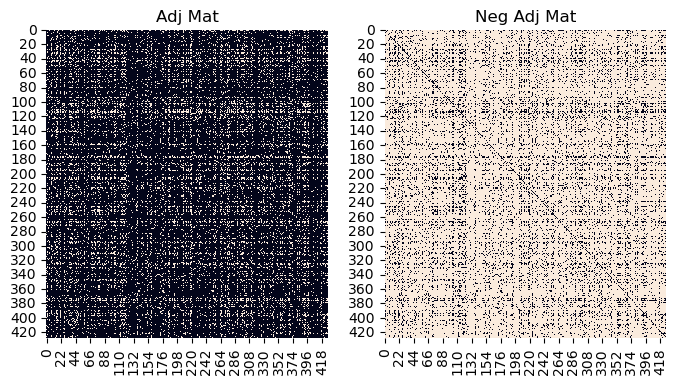

In [17]:
fig = plt.figure(figsize=(8, 4))
axes = fig.subplots(1, 2)

sns.heatmap(adjaceny_matrix.todense(), label='Adj Mat', ax=axes[0], cbar=False);
axes[0].set_title('Adj Mat');
sns.heatmap(adjaceny_matrix_negative, label='Neg Adj Mat', ax=axes[1], cbar=False);
axes[1].set_title('Neg Adj Mat');

In [18]:
from gode.odeblock import ODEBlock
from gode.gde import GDEFunc
from gode.dgl import DGLSAGEConv, DGLGATConv, MeanAttentionLayer

from gode.data import (
    make_mean_data_ti, make_train_test_dataframe, 
    get_data_ti, representative_cell_types_at_t,
    sample_group_index, sample_aggregate_group_at_t
)

def get_data_ti(
    df:pd.DataFrame, 
    t, 
    size:int,
    features,
    replace:bool=False,
    time_key:str='pseudotime',
    groupby:str='cell_types',
    device:torch.device=None
):
    if device is None:
        device = get_device()
        
    return torch.Tensor(
        sample_aggregate_group_at_t(
            df, t, time_key=time_key, 
            size=size, replace=replace,
            groupby=groupby, features=features
        ).values
    ).T#.to(device).T


In [19]:
def get_n_cells_of_type_k_at_time_t(df, n, k, t, genes=top_genes):
    n_genes = len(genes)
    groups = df.groupby(['cell_types', 'pseudotime'])
    if (k, t) not in groups.groups:
        values = np.array([[0 for cell in range(n)] for gene in range(n_genes)])
    else:
        values = groups.get_group((k, t))\
            .filter(genes).sample(n, replace=True)\
            .values.T
        
    # e.g. shape = (100 genes, 10 cells)
    genes_x_cells = values
    return genes_x_cells

In [20]:
gene_subset_indices = np.where(np.isin(traj_data['genes'], top_genes))[0] # indices of the genes in traj_data['genes']
np.random.seed(32)
cell_subset_indices = np.random.choice(traj_data['trajectories'].shape[1], 50, replace=False)

trajs = traj_data['trajectories']
trajs = trajs[::3]
trajs = trajs[:, cell_subset_indices]
trajs = trajs[:, :, gene_subset_indices]

In [21]:
pseudotimes = np.linspace(0, 1, trajs.shape[0])

In [22]:
traj_data['annotations']

array([0, 7, 1, 2, 5, 5, 1, 5, 5, 5, 7, 5, 0, 0, 0, 2, 7, 1, 1, 6, 0, 0,
       0, 1, 0, 0, 2, 0, 0, 1, 6, 7, 2, 1, 0, 1, 0, 2, 4, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 3, 7, 0, 7, 6, 3, 0, 0, 1, 0, 3, 0, 0, 5, 6, 0, 1, 7,
       0, 3, 0, 7, 7, 0, 0, 7, 0, 3, 0, 6, 1, 1, 7, 4, 1, 5, 0, 1, 3, 0,
       1, 3, 5, 0, 5, 6, 0, 0, 7, 1, 0, 0], dtype=int32)

In [23]:
traj_f = trajs.reshape(-1, trajs.shape[2]) # (time_points, cells, genes) --> (time_points * cells, genes)

# repeats the annotations so that each cell type annotation corresponds to multiple time points
annot_repeated = np.repeat(traj_data['annotations'][cell_subset_indices], trajs.shape[0]) # trajs - (timepoints, cells, genes)

# repeats the pseudotime values for each cell
pt_repeated = np.tile(pseudotimes, trajs.shape[1])

df = pd.DataFrame(traj_f, columns=top_genes, index=[f'cell_{i}' for i in range(traj_f.shape[0])])
df['pseudotime'] = pt_repeated
df['cell_types'] = [f'cell_type_{a}' for a in annot_repeated]

In [24]:
df

,SPSB1,MARCKSL1,DAB1,PDE4B,SLC44A5,ADGRL2,TXNIP,KCNN3,ADAMTS4,HSPA6,...,UQCR10,MAFF,SREBF2-AS1,SREBF2,SYAP1,PRDX4,PCDH11X,PCDH11Y,pseudotime,cell_types
cell_0,0.063354,0.005031,0.652503,1.586983,0.157087,0.255047,0.315828,0.032917,0.018818,0.150446,...,0.075213,0.007712,0.004482,0.564452,0.135319,0.019076,0.067920,0.067287,0.000000,cell_type_0
cell_1,0.054240,-0.009527,0.444088,1.866791,0.058598,0.075102,0.427096,0.007456,0.019458,0.117552,...,0.080296,-0.001976,0.006041,0.394402,0.145431,0.036640,0.019855,0.042075,0.030303,cell_type_0
cell_2,0.046845,0.010892,0.664044,1.494797,0.204193,0.340535,0.295971,0.051586,0.018451,0.136923,...,0.055823,0.004633,0.004551,0.444218,0.118563,0.010352,0.093364,0.080496,0.060606,cell_type_0
cell_3,0.033988,0.020608,0.720836,1.232844,0.268764,0.472679,0.223011,0.072855,0.016445,0.120572,...,0.039946,0.017852,0.003533,0.418860,0.112019,0.003358,0.135373,0.100804,0.090909,cell_type_0
cell_4,0.074697,-0.002614,0.600009,1.792545,0.103680,0.183077,0.293659,0.026199,0.022763,0.171148,...,0.062729,0.001665,0.006492,0.545701,0.158858,0.045858,0.054821,0.058670,0.121212,cell_type_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1695,0.053986,0.010004,0.557881,0.928407,0.111329,0.246781,0.639122,0.020104,0.003374,0.109588,...,0.072040,0.010661,0.004094,0.569876,0.143281,0.042430,0.068865,0.047129,0.878788,cell_type_5
cell_1696,0.090374,0.011502,0.578805,0.798947,0.129077,0.289629,0.472164,0.041271,0.008503,0.100474,...,0.081978,0.012999,0.004755,0.505663,0.136267,0.056752,0.103283,0.060003,0.909091,cell_type_5
cell_1697,0.031169,0.007198,0.539208,0.740957,0.108968,0.297919,0.716665,0.047434,0.000753,0.081324,...,0.018713,0.018180,0.008083,0.347303,0.128419,0.024417,0.074641,0.060922,0.939394,cell_type_5
cell_1698,0.037783,0.008059,0.426988,0.972625,0.065162,0.177945,0.620627,0.024120,0.006695,0.131310,...,0.059205,0.019661,0.005691,0.584671,0.165826,0.051319,0.051382,0.012528,0.969697,cell_type_5


In [25]:
def get_n_cells_of_all_types_at_time_t(df, n, t, types=np.unique(df['cell_types']), genes=top_genes):
    return np.hstack(tuple([
        get_n_cells_of_type_k_at_time_t(df, n, k, t, genes=genes)
        for k in types
    ]))

In [26]:
# import pca
import phate
phate_operator = phate.PHATE(t=100)
t_phate = phate_operator.fit_transform(traj_f)

Calculating PHATE...
  Running PHATE on 1700 observations and 428 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...


    Calculated PCA in 0.40 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.25 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.66 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.54 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.35 seconds.
Calculated PHATE in 3.56 seconds.


/gpfs/gibbs/project/gerstein/kx44/conda_envs/ritini/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/gpfs/gibbs/project/gerstein/kx44/conda_envs/ritini/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/gpfs/gibbs/project/gerstein/kx44/conda_envs/ritini/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/gpfs/gibbs/project/gerstein/kx44/conda_envs/ritini/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: >

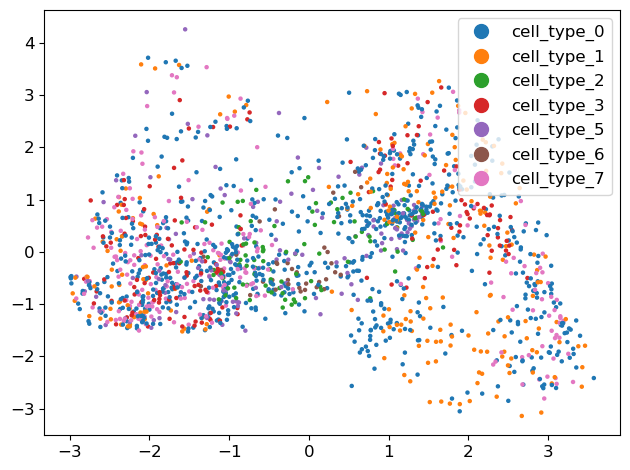

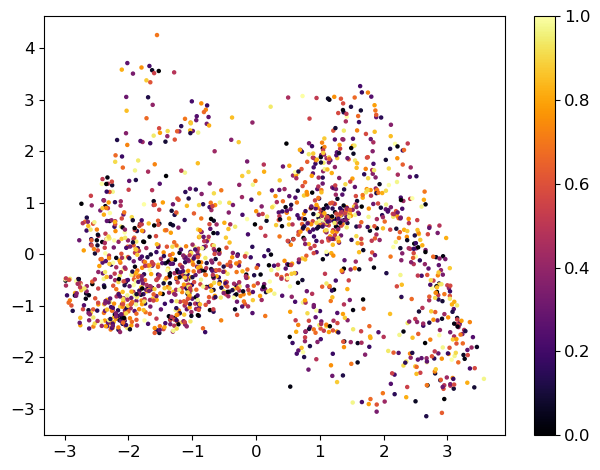

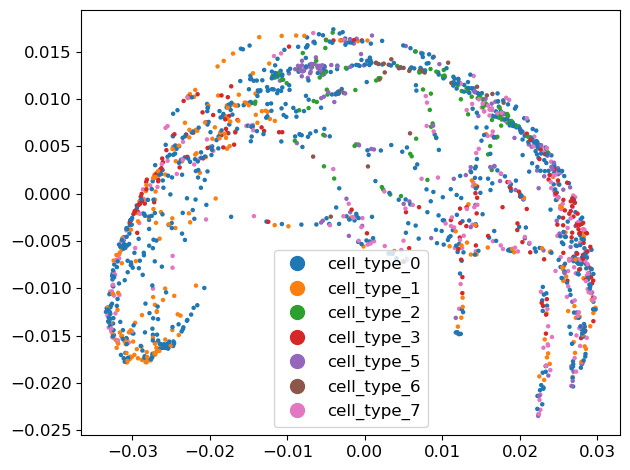

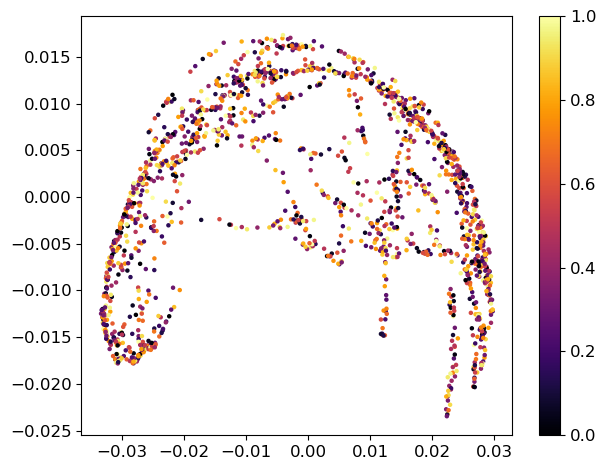

In [27]:
import scprep
scprep.plot.scatter2d(phate_operator.graph.data_nu, df['cell_types'])
scprep.plot.scatter2d(phate_operator.graph.data_nu, df['pseudotime'])
scprep.plot.scatter2d(t_phate, df['cell_types'])
scprep.plot.scatter2d(t_phate, df['pseudotime'])

In [28]:
df_train, df_test = make_train_test_dataframe(df)

In [29]:
neg_u, neg_v = np.where(adjaceny_matrix_negative != 0)
neg_edge_ids = np.random.choice(len(neg_u), g.number_of_edges())

edge_test_neg_u = neg_u[neg_edge_ids[:edge_test_size]]
edge_test_neg_v = neg_v[neg_edge_ids[:edge_test_size]]
edge_train_neg_u = neg_u[neg_edge_ids[edge_test_size:]]
edge_train_neg_v = neg_v[neg_edge_ids[edge_test_size:]]

In [30]:
train_g = dgl.remove_edges(g, edge_ids[:edge_test_size]) # a copy of original graph with test edge removed 

train_pos_g = dgl.graph(
    (edge_train_pos_u, edge_train_pos_v), 
    num_nodes=g.number_of_nodes() # ensure the graph has the same number of nodes as the original graph g 
)

train_neg_g = dgl.graph(
    (edge_train_neg_u, edge_train_neg_v), 
    num_nodes=g.number_of_nodes()
)

test_pos_g = dgl.graph(
    (edge_test_pos_u, edge_test_pos_v), 
    num_nodes=g.number_of_nodes()
)

test_neg_g = dgl.graph(
    (edge_test_neg_u, edge_test_neg_v), 
    num_nodes=g.number_of_nodes()
)

In [31]:
class DGLGATConv(conv.GATConv):
    def __init__(self, graph, in_feats, out_feats, num_heads, feat_drop=0.0, attn_drop=0.0, negative_slope=0.2, residual=False, activation=None, allow_zero_in_degree=False, bias=True):
        super(DGLGATConv, self).__init__(in_feats, out_feats, num_heads, feat_drop, attn_drop, negative_slope, residual, activation, allow_zero_in_degree, bias)
        self.graph = graph

    def forward(self, feat, get_attention=False):
        return super().forward(self.graph, feat, edge_weight=None, get_attention=get_attention) # updated to address a possible api change in the latest version.

In [32]:
n_cells_at_t = df['pseudotime'].value_counts()[0] # how many cells are present at each pseudotime point (as equal num at each time point) 50

time_bins = np.sort(df.pseudotime.unique())
cell_types = np.sort(df.cell_types.unique()) # 7

t0, *_, tn = time_bins
time_tensor = torch.Tensor(time_bins)#.to(device)

in_feats = cell_types.size * n_cells_at_t
out_feats = cell_types.size * n_cells_at_t

print(f"n_cells_at_t: {n_cells_at_t}")
print(f"time_bins: {time_bins}")
print(f"cell_types: {cell_types}")
print(f"t0: {t0}, tn: {tn}")
print(f"time_tensor: {time_tensor}")
print(f"in_feats: {in_feats}, out_feats: {out_feats}")

n_cells_at_t: 50
time_bins: [0.         0.03030303 0.06060606 0.09090909 0.12121212 0.15151515
 0.18181818 0.21212121 0.24242424 0.27272727 0.3030303  0.33333333
 0.36363636 0.39393939 0.42424242 0.45454545 0.48484848 0.51515152
 0.54545455 0.57575758 0.60606061 0.63636364 0.66666667 0.6969697
 0.72727273 0.75757576 0.78787879 0.81818182 0.84848485 0.87878788
 0.90909091 0.93939394 0.96969697 1.        ]
cell_types: ['cell_type_0' 'cell_type_1' 'cell_type_2' 'cell_type_3' 'cell_type_5'
 'cell_type_6' 'cell_type_7']
t0: 0.0, tn: 1.0
time_tensor: tensor([0.0000, 0.0303, 0.0606, 0.0909, 0.1212, 0.1515, 0.1818, 0.2121, 0.2424,
        0.2727, 0.3030, 0.3333, 0.3636, 0.3939, 0.4242, 0.4545, 0.4848, 0.5152,
        0.5455, 0.5758, 0.6061, 0.6364, 0.6667, 0.6970, 0.7273, 0.7576, 0.7879,
        0.8182, 0.8485, 0.8788, 0.9091, 0.9394, 0.9697, 1.0000])
in_feats: 350, out_feats: 350


In [33]:
nodes_names = [top_genes[i] for i in train_g.nodes().numpy()]
node_map_full = {n:i for i, n in enumerate(nodes_names)} # creates a dictionary that maps each gene name (n) to its corresponding index (i).
# tfs = 'gene_0 gene_10 gene_20 gene_30'.split()
tfs = top_genes[::5]

In [34]:
gnn = nn.Sequential( 
    DGLGATConv(
        train_g,
        in_feats=in_feats, out_feats=out_feats, 
        num_heads=1, residual=False,
        activation=nn.Tanh(),
        feat_drop=0.0, attn_drop=0.0,
        allow_zero_in_degree=True
    ),
    MeanAttentionLayer(),
)

gdefunc = GDEFunc(gnn)
gde = ODEBlock(func=gdefunc, method='rk4', atol=1e-3, rtol=1e-4, adjoint=False).to(device)
model = gde

In [35]:
def get_edges_from_graph(g):
    u, v = g.edges()
    u = u.numpy().tolist()
    v = v.numpy().tolist()
    edges = np.vstack((u, v)).T
    return edges

def get_missing_edges_from_edges(g): # calculates the missing edges in the graph g
    nodes = g.nodes().numpy().tolist()
    all_edges = list(itertools.product(nodes, nodes)) #  creates all possible combinations of pairs (u, v)
    edges = get_edges_from_graph(g).tolist()  
    return list(filter(lambda e: e not in edges, map(list, all_edges)))

In [36]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h): # g - graph, h - node feature matrix 
        with g.local_scope(): # creates a local context for g 
            g.ndata['h'] = h # assign the node feature h to graph g 
            
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            
            g.apply_edges(fn.u_dot_v('h', 'h', 'score')) # need to check what is v_dot_u
            
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]


# use MLP to predict edge scores                 
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):  # h_feats: humber of features for each nodes. 
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1) # horizontally 
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)} # 

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [37]:
pred = DotPredictor()

def compute_link_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [38]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=350, gamma=0.1)
criterion = torch.nn.MSELoss()

steps = 100
verbose_step = 1

lambda_l1 = 0.5

In [39]:
# from gode.plots import custom_features_over_time
from gode.data import make_results_dataframe, get_spearmanr

In [40]:
add_n = 5
del_n = 5
link_step = 2
sample_size = 10

In [41]:
data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, 0)
# data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1) 

In [45]:
num_cell_types = len(df['cell_types'].unique())
num_genes = len(top_genes)

In [42]:
data_t0.shape

(428, 350)

In [43]:
df_train

,SPSB1,MARCKSL1,DAB1,PDE4B,SLC44A5,ADGRL2,TXNIP,KCNN3,ADAMTS4,HSPA6,...,UQCR10,MAFF,SREBF2-AS1,SREBF2,SYAP1,PRDX4,PCDH11X,PCDH11Y,pseudotime,cell_types
cell_246,0.030895,0.020880,0.343463,1.194600,0.058694,0.160727,0.262619,0.025459,0.034826,0.104390,...,0.058416,-0.020337,0.005298,0.435295,0.092905,0.006173,0.047515,0.046323,0.242424,cell_type_0
cell_1695,0.053986,0.010004,0.557881,0.928407,0.111329,0.246781,0.639122,0.020104,0.003374,0.109588,...,0.072040,0.010661,0.004094,0.569876,0.143281,0.042430,0.068865,0.047129,0.878788,cell_type_5
cell_1185,0.026402,0.033966,0.672900,0.766235,0.245622,0.487295,0.561457,0.064743,0.003177,0.092431,...,0.086661,0.028820,0.006240,0.502543,0.135375,0.057526,0.126608,0.066736,0.878788,cell_type_7
cell_1325,0.044425,0.020975,0.508641,0.542113,0.101496,0.259702,0.690952,0.019744,0.009457,0.107342,...,0.124104,-0.002882,0.017274,0.370716,0.090629,0.065680,0.080963,0.062986,1.000000,cell_type_0
cell_1503,0.043517,0.017063,0.515411,0.556581,0.097799,0.223324,0.470316,0.012259,0.008238,0.057503,...,0.072112,0.002656,0.011072,0.489579,0.142771,0.042307,0.062724,0.063442,0.212121,cell_type_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1650,0.052151,0.014218,0.566049,0.837130,0.133337,0.285873,0.754609,0.034680,0.006199,0.087875,...,0.082176,0.018598,0.008688,0.476046,0.151679,0.051238,0.098094,0.055952,0.545455,cell_type_0
cell_1594,0.075742,0.003697,0.527580,1.074581,0.061940,0.192557,0.460647,0.023846,0.003339,0.130066,...,0.051235,0.013514,0.004479,0.511156,0.149858,0.042534,0.064283,0.041299,0.909091,cell_type_0
cell_1247,0.044911,0.008010,0.461731,0.978800,0.104957,0.294279,0.769432,0.032948,0.004635,0.175909,...,0.045987,0.021101,0.008322,0.553084,0.177910,0.041341,0.065313,0.030963,0.696970,cell_type_3
cell_124,0.063506,-0.001209,0.514265,1.372793,0.095923,0.171769,0.280948,0.029557,0.023473,0.130040,...,0.074886,-0.005090,0.009974,0.501674,0.111706,0.025703,0.042038,0.052396,0.666667,cell_type_1


In [46]:
device = 'cpu'
DATA_DIR = './'
model = model.to(device) #  Moves the model to the specified device.
attentions = {} # Initializes an empty dictionary to store attention scores

for step_i in range(steps):   
    
    data_tps = [] # store the predicted data (node features)
    data_tis = [] # store the input node features
    for _t, time_i in enumerate(time_bins[:-1]):   # _t is the index of the current time step, and time_i is the current time point. 
        
        data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
        data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
        data_t0 = torch.Tensor(data_t0)#.to(device)
        data_t1 = torch.Tensor(data_t1)#.to(device)
        
        t0 = time_bins[_t]
        t1 = time_bins[_t + 1]
        
        model.train() # set the model to training model        
        data_tp = model(
            data_t0,  
            torch.Tensor([t0, t1]),#.to(device), 
            return_whole_sequence=False
        )    
                
        pos_score = pred(train_pos_g, data_tp)
        neg_score = pred(train_neg_g, data_tp)
        link_loss = compute_link_loss(pos_score, neg_score)
        
        # Accesses the first layer of the GNN inside the model
        _, attn = model.func.gnn[0](data_t0, get_attention=True) # applies a Graph Attention Network (GAT) layer and retrieves the attention weights
    
        loss = criterion(data_tp, data_t1) + 10 * link_loss # + lambda_l1 * torch.norm(attn, 1)
        
        optimizer.zero_grad() #  Clears the gradients from the previous step
        loss.backward() # Performs backpropagation
        optimizer.step() # Updates the model parameters

        if _t == 0:
            data_tis.append(data_t0.clone().detach())
        data_tis.append(data_t1.clone().detach())
        data_tps.append(data_tp.clone().detach())
        
    # Every link_step (which is set to 2 steps), you update the graph structure by adding and removing edges.
    if step_i % link_step == 0:
        model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            # HANDLE LINKS - Update the graph by finding edges to add or remove.
            # Find edges to add

            # Get the missing edges from the current training graph (edges that don't exist but could).
            missing_edges = np.array(get_missing_edges_from_edges(train_g)).T
            missing_u, missing_v = missing_edges

            # Create a graph object for the missing edges.
            missing_g = dgl.graph(
                (torch.IntTensor(missing_u), torch.IntTensor(missing_v)), 
                num_nodes=g.number_of_nodes()
            )
            
            missing_score = pred(missing_g, data_tp) # this is the Dotpredictor (predict score)
            missing_idxs = np.argsort(missing_score.numpy()) #  # Sort the missing edges by their predicted scores.
 
            # Select the best missing edges to add (with the highest predicted scores).
            best_u = missing_u[missing_idxs[-add_n:]] # Top 'add_n' edges with highest scores.
            best_v = missing_v[missing_idxs[-add_n:]] # Top 'add_n' edges with highest scores.

            # Find edges to remove
            current_u, current_v = get_edges_from_graph(train_g).T

            current_scores = pred(train_g, data_tp) # # Predict the scores for the existing edges.
            current_idxs = np.argsort(current_scores.numpy()) # # Sort the edges by their scores.

            # Select the worst edges to remove (with the lowest predicted scores).
            worst_u = current_u[current_idxs[:del_n]]
            worst_v = current_v[current_idxs[:del_n]]

            # Get the edge IDs of the worst edges to be removed.
            to_remove = train_g.edge_ids(torch.IntTensor(worst_u), torch.IntTensor(worst_v))

            # Remove the worst edges and add the best new edges to the training graph
            train_g.remove_edges(to_remove)

            # Add the best new edges to the graph.
            train_g.add_edges(torch.IntTensor(best_u), torch.IntTensor(best_v))

    # Step the learning rate scheduler   
    scheduler.step()   
    
    # Print the training loss and evaluation metrics
    if step_i % verbose_step == 0:
        model.eval()
        with torch.no_grad():
        
            data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
            data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
            data_t0 = torch.Tensor(data_t0)#.to(device)
            data_t1 = torch.Tensor(data_t1)#.to(device)

            # Get the model's predicted features for the entire sequence
            data_tp = model(data_t0,  time_tensor, return_whole_sequence=True)

            pos_score = pred(test_pos_g, data_tp[-1]) # this is the Dotpredictor (predict score)
            neg_score = pred(test_neg_g, data_tp[-1])
            auc_score = compute_auc(pos_score, neg_score)
            print('[{}],\t Loss: {:3.5f},\t AUC: {:3.5f}'.format(step_i + 1, loss, auc_score)) 
        
            attns = np.empty(0)
            data_tp = data_tps
            data_tps = []
            data_tis = []

            # Loop over each time point again to compute attention scores and store results.
            for _t, time_i in enumerate(time_bins[:-1]): 

                data_t0 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t)
                data_t1 = get_n_cells_of_all_types_at_time_t(df_train, n_cells_at_t, _t + 1)        
                data_t0 = torch.Tensor(data_t0)#.to(device)
                data_t1 = torch.Tensor(data_t1)#.to(device)

                t0 = time_bins[_t]
                t1 = time_bins[_t + 1]

                data_tp = model(
                    data_t0,  
                    torch.Tensor([t0, t1]),#.to(device), 
                    return_whole_sequence=False
                )    

                if _t == 0:
                    data_tis.append(data_t0.clone().detach())
                data_tis.append(data_t1.clone().detach())
                data_tps.append(data_tp.clone().detach())

                _, attn = model.func.gnn[0](data_t0, get_attention=True)

                attn = attn.reshape(-1).detach().cpu().numpy()  # Reshape and convert attention weights to a NumPy array.       
                attns = np.vstack((attns, attn)) if attns.size else attn  # Accumulate the attention scores for all time points.

            attns = np.array(attns)
            
            # Every 10 steps, store the attention scores for visualization and analysis.
            if step_i in np.arange(0, steps, 10):#[0, int(steps/2), steps-1]:
                data_ti = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tis]))
                data_tp = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tps]))
                
                dti = data_ti.detach().numpy() # Detach the data to free up resources
                dtp = data_tp.detach().numpy()
                
                idx = np.arange(num_cell_types) * n_cells_at_t - 1
                idx[0] = 0
                
                dti_t = torch.Tensor(dti[:, :, idx])
                dtp_t = torch.Tensor(dtp[:, :, idx])
                
                # Store the attention scores for the current step.
                attentions[step_i] = np.array(attns)
                
            # Convert predicted features to NumPy arrays for analysis or further processing.    
            data_tp = np.array([t.detach().cpu().numpy() for t in data_tps])

[1],	 Loss: 6.93155,	 AUC: 0.55198
[2],	 Loss: 6.93155,	 AUC: 0.55522
[3],	 Loss: 6.93155,	 AUC: 0.55437
[4],	 Loss: 6.93155,	 AUC: 0.55564
[5],	 Loss: 6.93155,	 AUC: 0.57383
[6],	 Loss: 6.93155,	 AUC: 0.55793
[7],	 Loss: 6.93155,	 AUC: 0.55451
[8],	 Loss: 6.93155,	 AUC: 0.54850
[9],	 Loss: 6.93155,	 AUC: 0.55439
[10],	 Loss: 6.93155,	 AUC: 0.55016
[11],	 Loss: 6.93155,	 AUC: 0.55448
[12],	 Loss: 6.93155,	 AUC: 0.55866
[13],	 Loss: 6.93155,	 AUC: 0.55790
[14],	 Loss: 6.93155,	 AUC: 0.54580
[15],	 Loss: 6.93155,	 AUC: 0.53993
[16],	 Loss: 6.93155,	 AUC: 0.55927
[17],	 Loss: 6.93155,	 AUC: 0.55751
[18],	 Loss: 6.93156,	 AUC: 0.55292
[19],	 Loss: 6.93156,	 AUC: 0.56317
[20],	 Loss: 6.93156,	 AUC: 0.54663
[21],	 Loss: 6.93156,	 AUC: 0.55758
[22],	 Loss: 6.93156,	 AUC: 0.56209
[23],	 Loss: 6.93156,	 AUC: 0.56277
[24],	 Loss: 6.93156,	 AUC: 0.55998
[25],	 Loss: 6.93156,	 AUC: 0.53660
[26],	 Loss: 6.93156,	 AUC: 0.56485
[27],	 Loss: 6.93156,	 AUC: 0.57243
[28],	 Loss: 6.93156,	 AUC: 0.55004
[

In [47]:
data_ti = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tis]))
data_tp = torch.Tensor(np.array([t.detach().cpu().numpy() for t in data_tps]))

dti = data_ti.detach().numpy()
dtp = data_tp.detach().numpy()

idx = np.arange(num_cell_types) * n_cells_at_t - 1
idx[0] = 0
idx

torch.save(data_ti, 'data_ti.pt')
torch.save(data_tp, 'data_tp.pt')

In [48]:
# Move model to CPU before saving to avoid CUDA issues
model_cpu = model.cpu()
torch.save(model_cpu.state_dict(), 'model_state_dict.pt')
# If you need to save the entire model structure as well, use:
torch.save(model_cpu, 'model_full.pt')
# Move model back to original device if needed
model = model.to(device)

In [49]:
dti_t = torch.Tensor(dti[:, :, idx])
dtp_t = torch.Tensor(dtp[:, :, idx])

In [50]:
df_res = make_results_dataframe(
    dti_t, dtp_t, 
    nodes_names, cell_types, tfs
)


In [51]:
df_corr = get_spearmanr(dti_t, dtp_t, columns=cell_types, index=node_map_full)

In [ ]:
df_res.to_csv('df_res.csv')
df_corr.to_csv('df_corr.csv')
# fig = custom_features_over_time(

In [ ]:
# fig = custom_features_over_time(
#     df_res, df_corr,
#     col='tf', row='cell_type',
#     hue='type', x='time', y='expression'
# )            

In [ ]:
nx_g = train_g.to_networkx()
# pos = nx.kamada_kawai_layout(nx_g, scale=1, dim=2)
import pickle
with open('graph.pkl', 'wb') as f:
    pickle.dump(nx_g, f)

In [ ]:
# nx_g = train_g.to_networkx()

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(1,1,1)

# nx.draw_networkx_labels(
#     nx_g, pos=ref_pos, ax=ax,
#     labels=nx.get_node_attributes(ref_g,'label'),
#     font_size=12, font_color='black'
# )

# nx.draw(
#     nx_g, pos=ref_pos, ax=ax,
#     with_labels=False,
#     node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
#     edge_cmap=plt.cm.magma,
#     node_size=500, arrowsize=25, alpha=0.7
# )

In [ ]:
# train_g.remove_edges(train_g.edge_ids(train_g.edges()[0][:100], train_g.edges()[1][:100]))

In [ ]:
# len(train_g.edges()[0])

In [ ]:
# nx_g = train_g.remove_self_loop().to_networkx()

# fig = plt.figure(figsize=(18, 18))
# ax = fig.add_subplot(1,1,1)

# nx.draw_networkx_labels(
#     nx_g, pos=ref_pos, ax=ax,
#     labels=nx.get_node_attributes(ref_g,'label'),
#     font_size=12, font_color='black'
# )

# nx.draw(
#     nx_g, pos=ref_pos, ax=ax,
#     with_labels=False,
#     # node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
#     node_color='lightblue', edge_color='gray',
#     # edge_cmap=plt.cm.magma,
#     node_size=500, arrowsize=25, alpha=0.7
# )

In [ ]:
# fig = plt.figure(figsize=(18, 18))
# ax = fig.add_subplot(1,1,1)

# nx.draw_networkx_labels(
#     ref_g, pos=ref_pos, ax=ax,
#     labels=nx.get_node_attributes(ref_g,'label'),
#     font_size=12, font_color='black'
# )

# nx.draw(
#     ref_g, pos=ref_pos, ax=ax,
#     with_labels=False,
#     # node_color=list(nx.get_node_attributes(ref_g, 'color').values()),
#     node_color='lightblue', edge_color='gray',
#     # edge_cmap=plt.cm.magma,
#     node_size=250, arrowsize=25, alpha=0.7
# )

In [ ]:
# import pickle
# with open('graph.pkl', 'wb') as f:
#     pickle.dump(nx_g, f)

In [ ]:
# adj_matrix = nx.to_numpy_array(nx_g)

# n_bins = 100  # Number of bins for interpolation

# plt.figure(figsize=(20, 18))  
# plt.imshow(adj_matrix, cmap='binary')
# plt.xticks(ticks=np.arange(len(top_genes)), labels=top_genes, rotation=90)
# plt.yticks(ticks=np.arange(len(top_genes)), labels=top_genes)

# cbar = plt.colorbar(label='Values', fraction=0.046, pad=0.04, shrink=0.8)
# cbar.ax.tick_params(labelsize=20)
# cbar.set_label('Values', fontsize=20)
# plt.title('GRN inferred from trajectories with Granger Causality', fontsize=20)
# plt.show()